# Cell-wise analyses:reveal dominant interactions across all cells



To obtain mechanistic insights into key regulatory motifs from different perspectives, we developed three complementary strategies: cell-wise, trajectory-wise and plane-wise analyses. In this tutorial, we will introduce approaches for gene network motif analysis and guide you to perform cell-wise analyses of SPI1-GATA1 network motif.

Import relevant packages

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import Scribe as sb
import sys
import os

# import scanpy as sc
import dynamo as dyn
import seaborn as sns

dyn.dynamo_logger.main_silence()


In [14]:
adata_labeling = dyn.sample_data.hematopoiesis()

## Three approaches for in-depth network motif characterizations
The schematic graph in this section shows the three approaches.
- cell-wise analyses to reveal dominant interactions across all cells
- trajectory-wise analyses reveal trajectory dependent interactions along a trajectory (predicted either from vector field streamline, or least action path, see Figure 6). 
- Plane-wise analyses reveal direct interactions for any characteristic cell states by varying genes of interest while holding all other genes constant.

In the next section, we will use **cell-wise analyses** to analyze PU.1/SPI1–GATA1 network motif.  

![fig5_h](images/fig5_h.png)

## Cell-wise analyses of the PU.1/SPI1–GATA1 network motif across all cells

We showcase cell-wise analyses with the canonical PU.1/SPI1-GATA1 network motif.

### Schematic of the SPI1-GATA1 toggle switch model

![fig5_I_i](images/fig5_I_i.png)

### Streamline plot of the RNA velocities of SPI1 (x-axis) and GATA1 (y-axis)

The streamlines of SPI1 and GATA1 show that HSPCs bifurcate into GMP-like and MEP-like branches

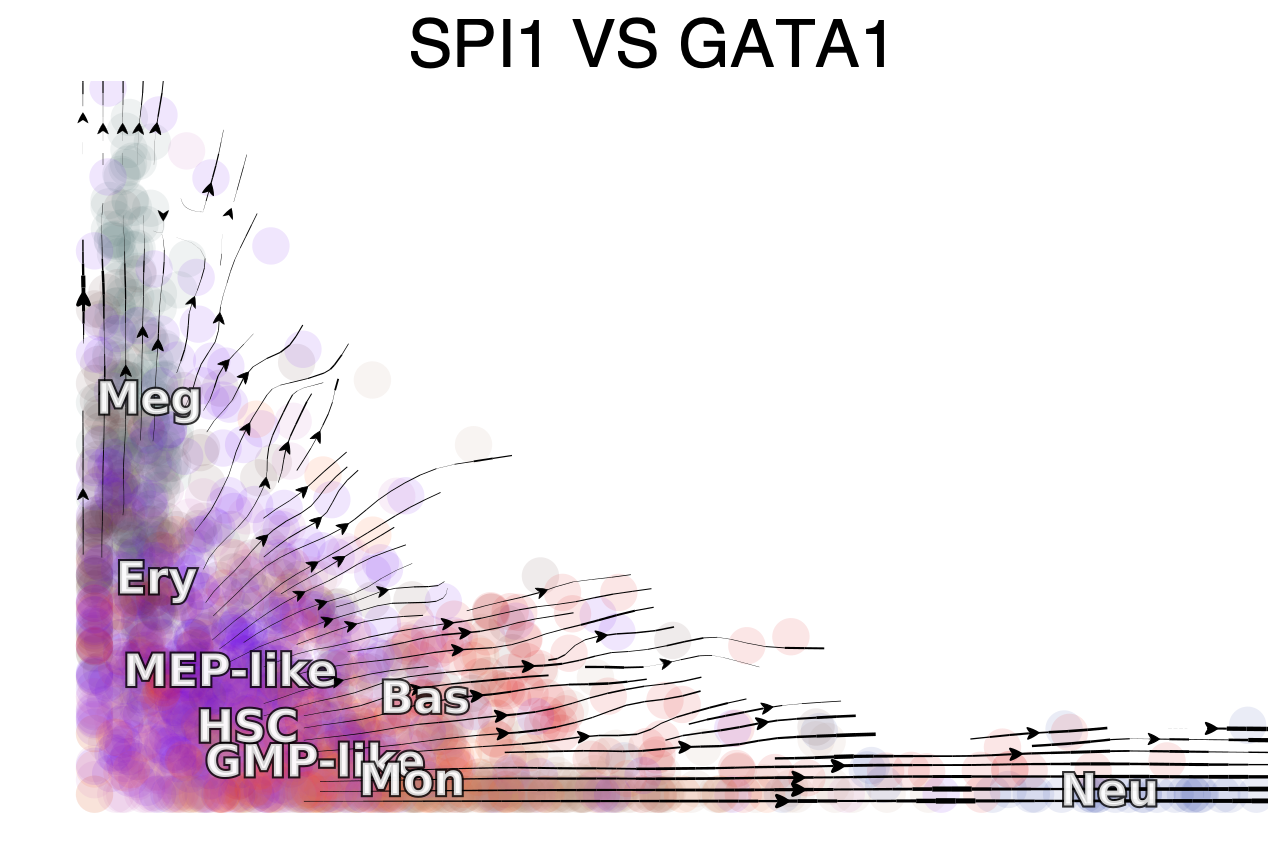

In [21]:
dyn.configuration.set_pub_style(scaler=4)
dyn.pl.streamline_plot(
    adata_labeling,
    color="cell_type",
    x="SPI1",
    y="GATA1",
    layer="M_t",
    ekey="M_t",
    pointsize=0.5,
    figsize=(8, 5),
    vkey="velocity_alpha_minus_gamma_s",
)


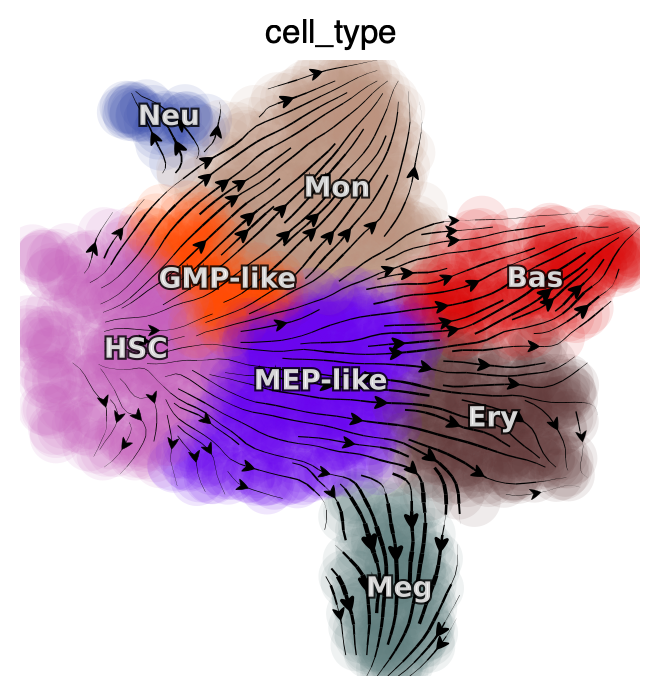

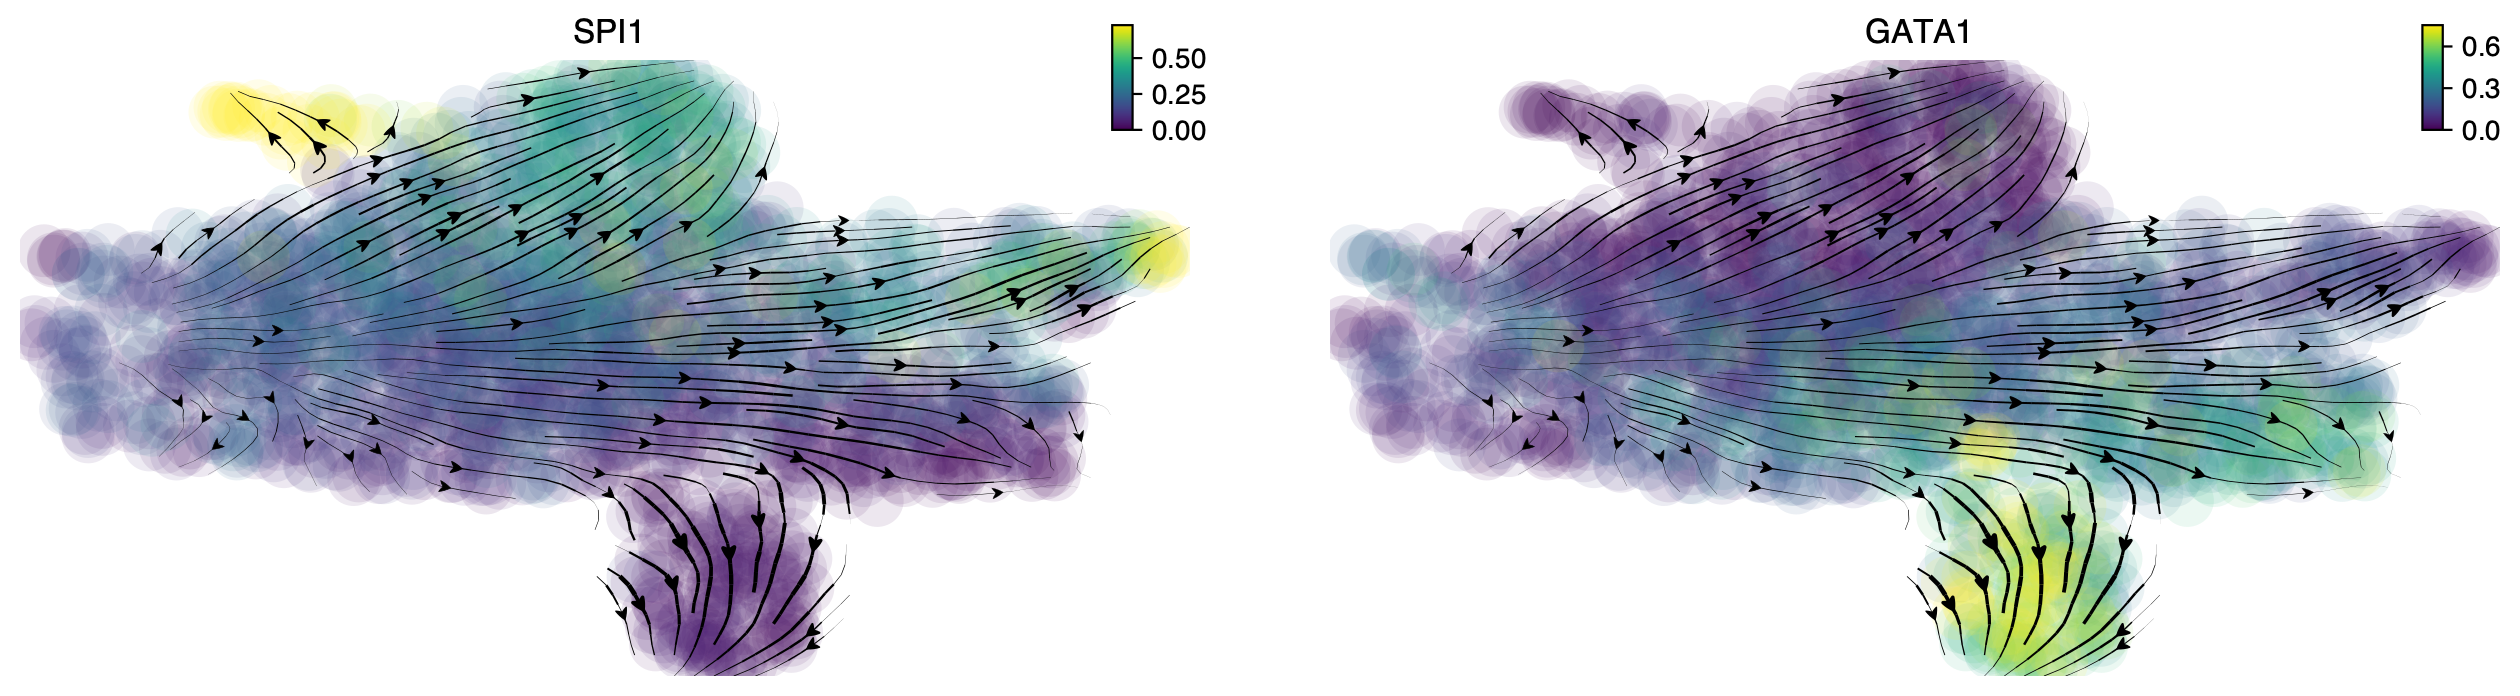

In [38]:
dyn.pl.streamline_plot(
    adata_labeling,
    color=["cell_type"],
    layer="M_t",
    figsize=(4, 4),
    ncols=2
)

dyn.pl.streamline_plot(
    adata_labeling,
    color=["SPI1", "GATA1"],
    layer="M_t",
    figsize=(8, 4),
    ncols=2
)

The streamlines above of SPI1 and GATA1 show that HSPCs bifurcate into GMP-like and MEP-like branches

Next we will use jacobian to show
- Repression from SPI1 to GATA1, GATA1 to SPI1
- self-activation of SPI1, and GATA1, in the SPI1 and GATA1 expression space

In particular, the repression from SPI1 to GATA1 is mostly discernable in progenitors (rectangle A: bottom left) but becomes negligible when either GATA1 is much higher than SPI1 (rectangle B: upper left) or GATA1 is close to zero (rectangle C: bottom right).

calculating Jacobian for each cell: 100%|██████████| 1947/1947 [00:00<00:00, 183195.59it/s]


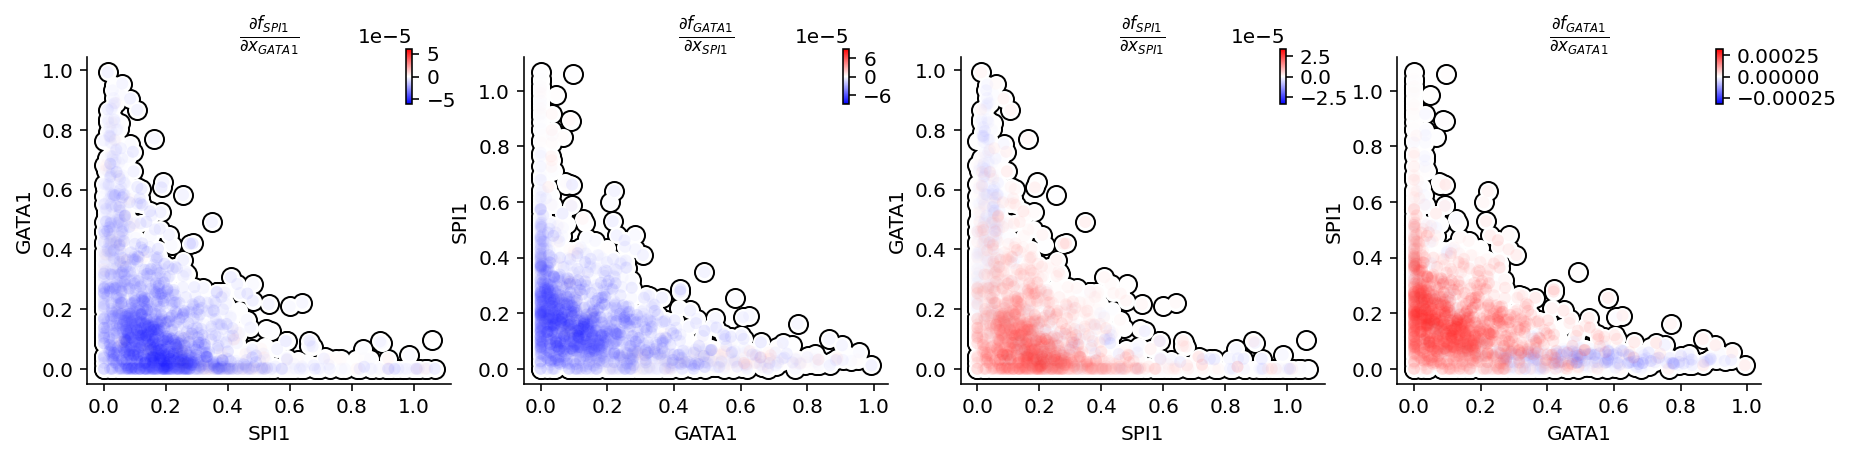

In [18]:
%matplotlib inline

genes = ["SPI1", "GATA1"]
def plot_jacobian_on_gene_axis(receptor, effector, x_gene=None, y_gene=None, axis_layer="M_t", temp_color_key="temp_jacobian_color", ax=None):
    if x_gene is None:
        x_gene = receptor
    if y_gene is None:
        y_gene = effector

    x_axis = adata_labeling[:, x_gene].layers[axis_layer].A.flatten(),
    y_axis = adata_labeling[:, y_gene].layers[axis_layer].A.flatten(),

    dyn.vf.jacobian(adata_labeling, regulators = [receptor, effector], effectors=[receptor, effector])
    J_df = dyn.vf.get_jacobian(
        adata_labeling,
        receptor,
        effector,
    )

    color_values = np.full(adata_labeling.n_obs, fill_value=np.nan)
    color_values[adata_labeling.obs["pass_basic_filter"]] =  J_df.iloc[:, 0]
    adata_labeling.obs[temp_color_key] = color_values

    ax = dyn.pl.scatters(
        adata_labeling,
        vmin=0,
        vmax=100,
        color=temp_color_key,
        cmap="bwr",
        sym_c=True,
        frontier=True,
        sort="abs",
        alpha=0.1,
        pointsize=0.1,
        x=x_axis,
        y=y_axis,
        save_show_or_return="return",
        despline=True,
        despline_sides=["right", "top"],
        deaxis=False,
        ax=ax,
    )
    ax.set_title(r"$\frac{\partial f_{%s}}{\partial x_{%s}}$" % (effector, receptor))
    ax.set_xlabel(x_gene)
    ax.set_ylabel(y_gene)
    adata_labeling.obs.pop(temp_color_key)

figure, axes = plt.subplots(1, 4, figsize=(15, 3))
plot_jacobian_on_gene_axis("GATA1", "SPI1", x_gene="SPI1", y_gene="GATA1", ax=axes[0])
plot_jacobian_on_gene_axis("SPI1", "GATA1", x_gene="GATA1", y_gene="SPI1", ax=axes[1])
plot_jacobian_on_gene_axis("SPI1", "SPI1", x_gene="SPI1", y_gene="GATA1", ax=axes[2])
plot_jacobian_on_gene_axis("GATA1", "GATA1", x_gene="GATA1", y_gene="SPI1",ax=axes[3])
plt.show()


### Response heatmap
White dashed lines indicate the minimum or maximum of repression or activation and the corresponding expression threshold.

Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 125048.77it/s]


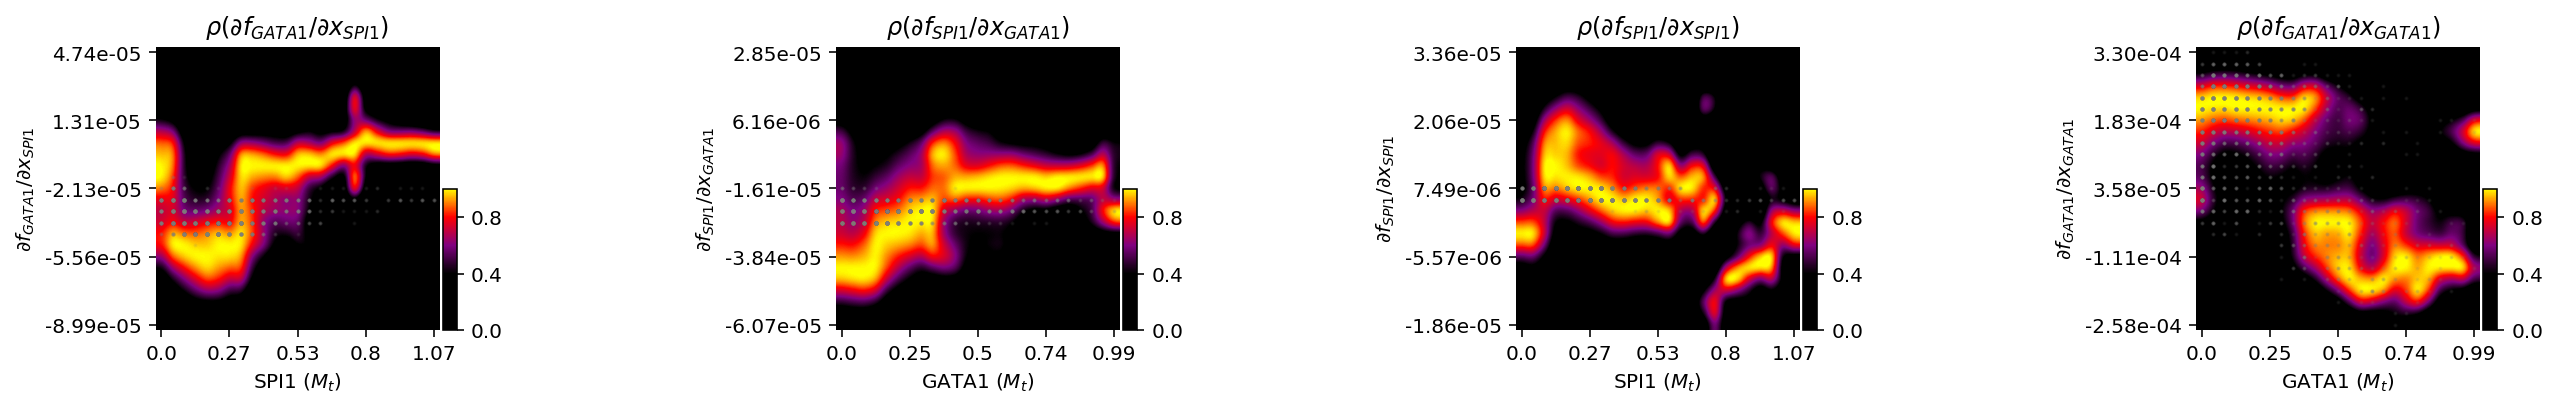

In [19]:
%matplotlib inline

dyn.vf.jacobian(adata_labeling, regulators=["SPI1", "GATA1"], effectors=["SPI1", "GATA1"])
dyn.pl.response(
    adata_labeling,
    np.array([["SPI1", "GATA1"], ["GATA1", "SPI1"], ["SPI1", "SPI1"], ["GATA1", "GATA1"]]),
    ykey="jacobian",
    log=False,
    drop_zero_cells=True,
    grid_num=25,
    figsize=(5, 3),
    save_show_or_return="show"
)

## Conclusion

In the analyses above, we illustrate how to use `dynamo` to perform cell-wise analysis to explore the canonical PU.1/SPI1-GATA1 network motif.